# <font color='darkorange'> 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns

# Libraries made for this project
from src                     import Starts, BayesianSearchCV

from matplotlib              import pyplot as plt
from unidecode               import unidecode
from dateutil.relativedelta  import relativedelta
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from category_encoders.count import CountEncoder
from sklearn.metrics         import mean_squared_error
from catboost                import CatBoostRegressor
from lightgbm                import LGBMRegressor
from datetime                import datetime, timedelta
from IPython.display         import Image


In [3]:
starts = Starts()

In [4]:
starts.jupyter_settings()

## <font color='darkorange'> 0.1. Helper Functions

In [5]:
def RMSE(y_pred, y_true):
    """
    Calculate the RMSE
    """
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [6]:
def univariate_categorical( series, text):
    """
    Print number of unique values and the percents of the values.
    """
    print(f'Numero de {text}: {series.nunique()}\n')
    print(f'Percentual de {text}: ')
    print(series.value_counts(normalize=True))

    return None

In [7]:
def split_names(data):

    """
    Split the airport names into airport name and corresponding state abbreviation.
    
    Args:
        data (DataFrame): Input DataFrame with columns 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome'.
    
    Returns:
        DataFrame: Modified input DataFrame with additional columns 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf'.
                   The 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome' columns are updated to contain only the airport names.
                   The 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf' columns are converted to the 'category' data type.
    """

    # Origem
    aeroporto_de_origem_uf = pd.DataFrame( data.aeroporto_de_origem_nome.str.split(',').str[1] )
    aeroporto_de_origem_uf = aeroporto_de_origem_uf.rename(columns={'aeroporto_de_origem_nome': 'aeroporto_de_origem_uf'})
    uf_completo = pd.DataFrame( data.aeroporto_de_origem_uf )
    uf_completo.update(aeroporto_de_origem_uf)
    data.aeroporto_de_origem_uf = uf_completo.astype('category')
    data.aeroporto_de_origem_nome = data.aeroporto_de_origem_nome.str.split(',').str[0].astype('category')

    # Destino
    aeroporto_de_destino_uf = pd.DataFrame( data.aeroporto_de_destino_nome.str.split(',').str[1] )
    aeroporto_de_destino_uf = aeroporto_de_destino_uf.rename(columns={'aeroporto_de_destino_nome': 'aeroporto_de_destino_uf'})
    uf_completo = pd.DataFrame( data.aeroporto_de_destino_uf )
    uf_completo.update(aeroporto_de_destino_uf)
    data.aeroporto_de_destino_uf = uf_completo.astype('category')
    data.aeroporto_de_destino_nome = data.aeroporto_de_destino_nome.str.split(',').str[0].astype('category')

    return data

def unicode_text( data ):
    """
    Transforme the text - strip and unidecode.
    """

    for col in data.select_dtypes(include=['category']).columns:
        data[col] = data[col].astype(str).str.strip().apply(lambda x: unidecode(x))
        data[col] = data[col].astype('category')
    
    return data

# <font color='darkorange'> 0.2. Load Data

In [8]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]

data = data.drop(columns=cols)
data = data.reset_index(drop=True)

# Split train test
train = data.query('date < "2023-03-01"')
test = data.query('date >= "2023-03-01"')

print(train.shape[0] + test.shape[0] == data.shape[0])
print(train.shape, test.shape)

True
(366265, 26) (1250, 26)


# <font color='darkorange'>  1.0 Data Descriptions

## <font color='darkorange'>  1.1. Check NA and dtypes

In [9]:
starts.data_dimensions(train)

Number of rows: 366265
Number of cols: 26


## <font color='darkorange'>  1.2. Data Dimensions

In [10]:
starts.type_na(train)

,Type,number na,percent na
empresa_nome,category,0,0.0 %
ano,int32,0,0.0 %
mes,int32,0,0.0 %
aeroporto_de_origem_sigla,category,0,0.0 %
aeroporto_de_origem_nome,category,0,0.0 %
aeroporto_de_origem_uf,category,16896,4.61 %
aeroporto_de_origem_regiao,category,16896,4.61 %
aeroporto_de_origem_pais,category,0,0.0 %
aeroporto_de_origem_continente,category,0,0.0 %
aeroporto_de_destino_sigla,category,0,0.0 %


- Faltam dados dos estados de origem e destino devido a estarem agrupados na mesma coluna

# <font color='darkorange'>  2. EDA

In [11]:
df2 = train.copy()

## <font color='darkorange'>  2.1. Descriptive Analysis

In [12]:
starts.statistics_info(df2)

,Non-Null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
ano,366265,23.00,2000.00,2003.00,2010.00,2016.00,2023.00,2009.98,6.97,0.12,-1.27
mes,366265,11.00,1.00,3.00,6.00,9.00,12.00,6.44,3.50,0.02,-1.25
distancia_voada_km,366265,682240.00,14.00,9464.00,25152.00,57483.00,682254.00,47401.39,63736.37,2.90,11.12
decolagens,366265,917.00,1.00,21.00,31.00,61.00,918.00,50.58,60.34,4.76,39.02
assentos,366265,154836.00,9.00,1404.00,4150.00,8988.00,154845.00,6935.85,9405.25,4.51,35.74
horas_voadas,366265,1432.68,0.52,24.55,53.39,107.84,1433.20,86.13,99.84,2.65,9.73
distancia_voada_km_por_voo,366265,9905.00,14.00,393.00,647.00,1218.00,9919.00,1108.09,1470.33,3.85,16.53
assentos_por_voo,366265,443.75,2.25,86.00,130.50,169.00,446.00,125.19,57.41,0.10,0.67
horas_voadas_por_voo,366265,23.05,0.50,1.05,1.43,2.14,23.55,1.93,1.77,3.73,16.42
passageiros,366265,93717.00,2.00,508.00,2129.00,5455.00,93719.00,4360.94,6568.69,3.97,25.99


- 22 anos de dados - 2001 - 2023
- 14 km de distancia como minimo me chama a atenção
- Registro com uma unica decolagem
- Decolagem com alta kurtosis, skew positiva
- Assentos com alta kurtosis, skew positiva
- Passageiros com alta kurtosis, skew positiva

## <font color='darkorange'>  2.2. Numerical Analysis

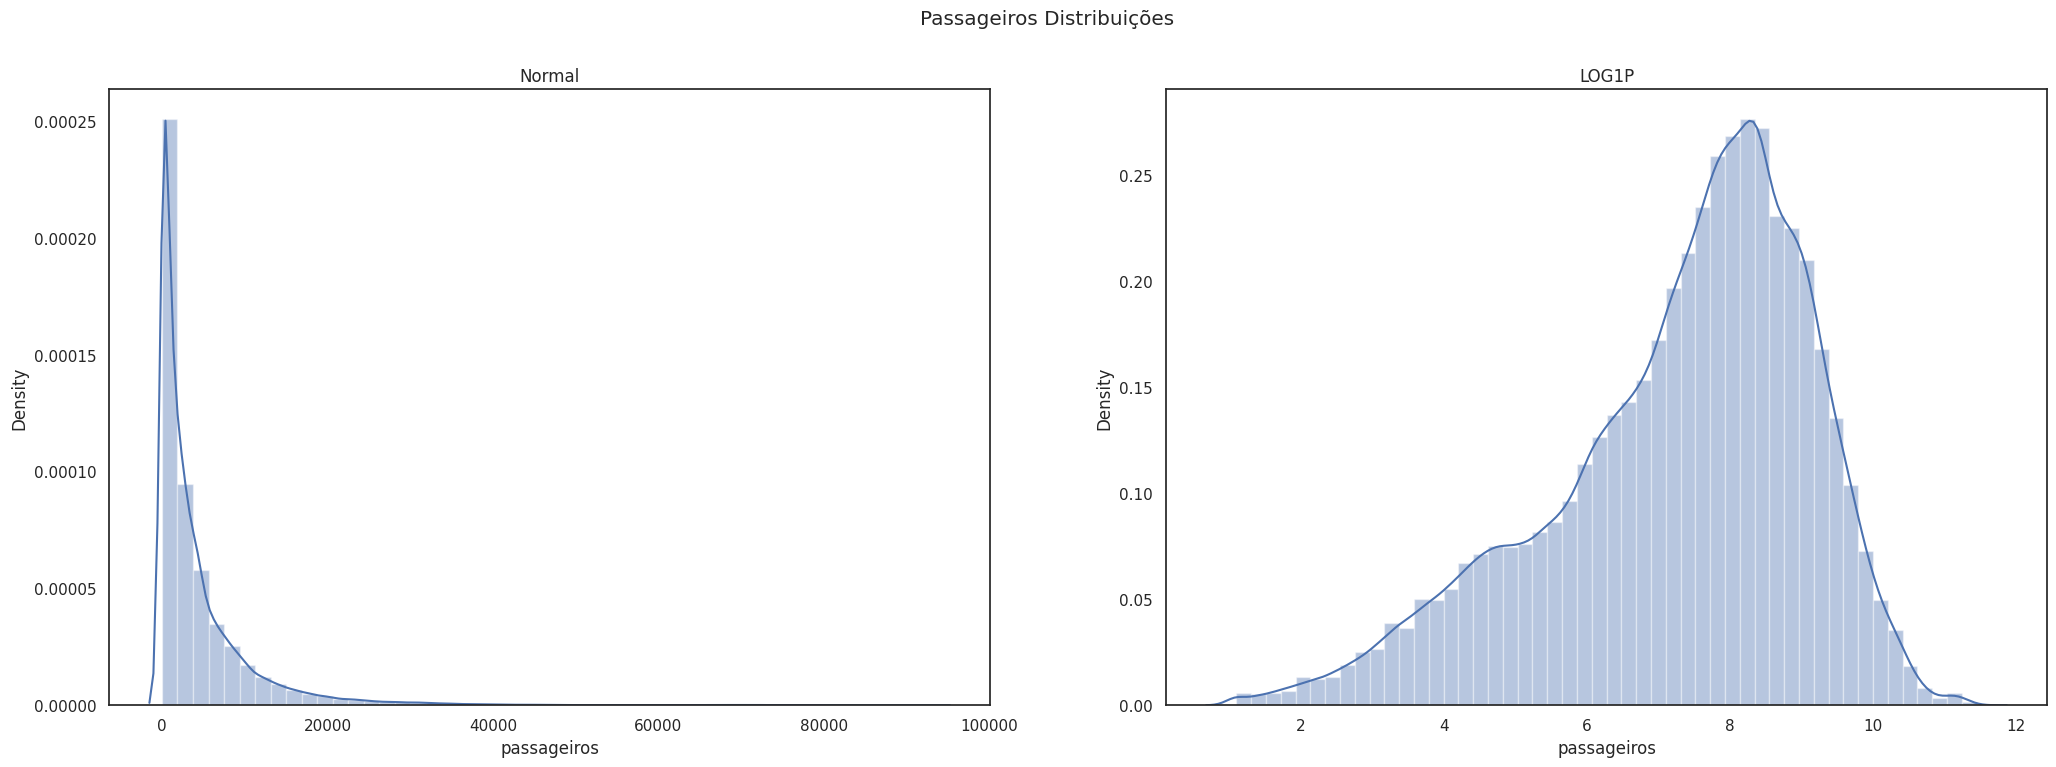

In [13]:
# target
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
fig.suptitle('Passageiros Distribuições')
sns.distplot((df2.passageiros), ax=axs[0]);
axs[0].set_title('Normal')
sns.distplot(np.log1p(df2.passageiros), ax=axs[1] );
axs[1].set_title('LOG1P');

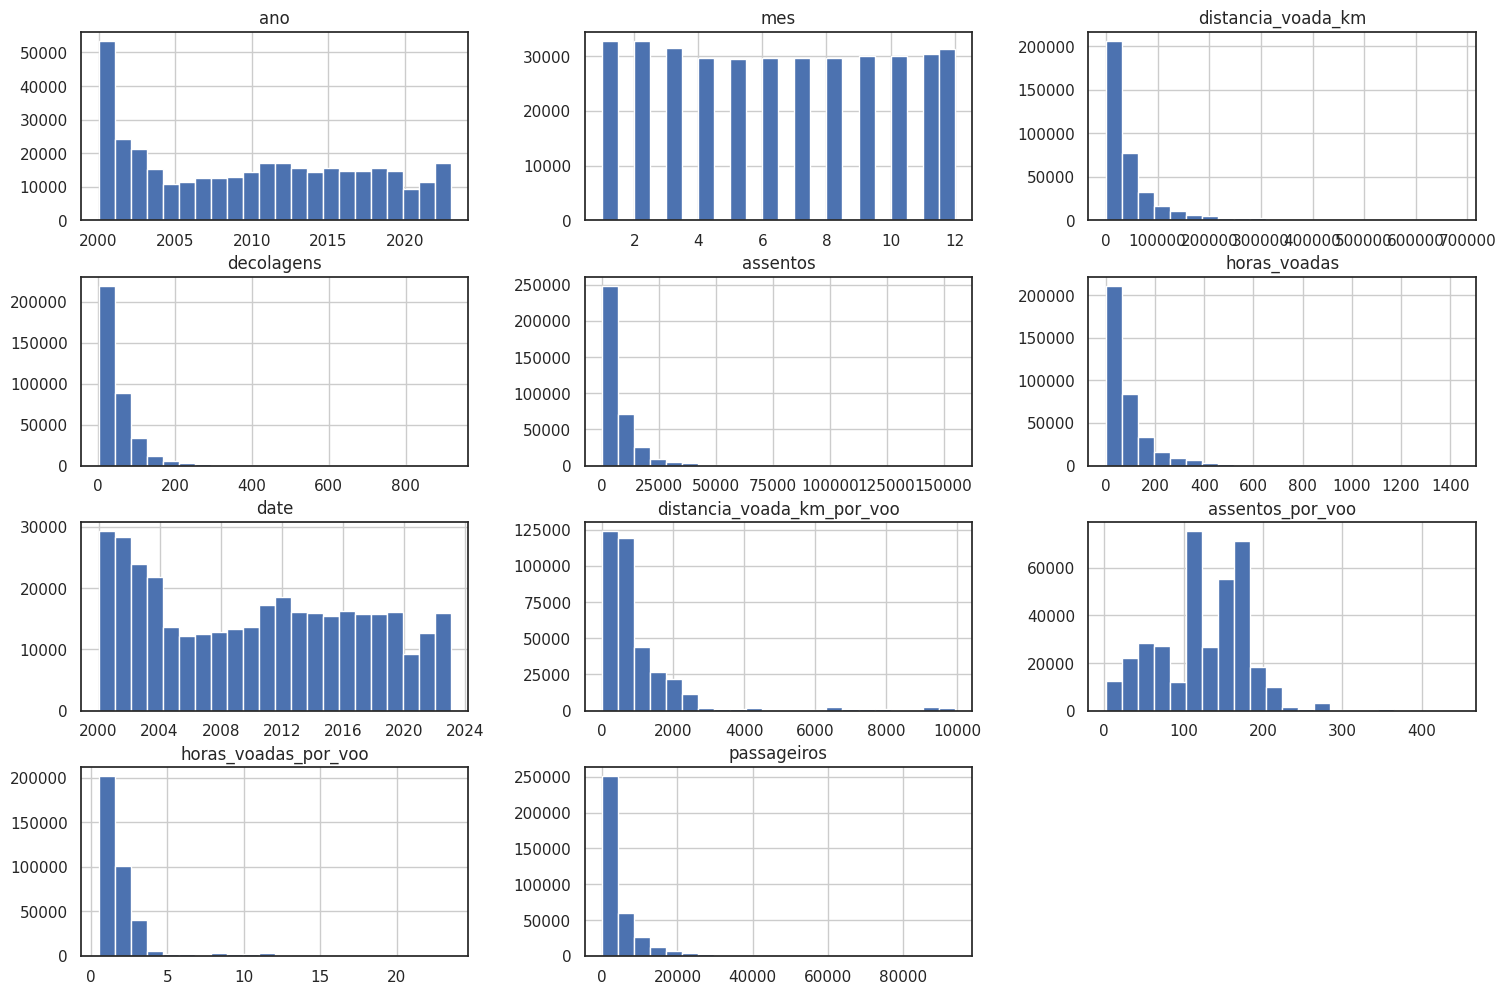

In [14]:
df2.hist(bins=22, figsize=(18,12));

In [15]:
df2.sort_values('passageiros', ascending=False)

,empresa_nome,ano,mes,aeroporto_de_origem_sigla,aeroporto_de_origem_nome,aeroporto_de_origem_uf,aeroporto_de_origem_regiao,aeroporto_de_origem_pais,aeroporto_de_origem_continente,aeroporto_de_destino_sigla,aeroporto_de_destino_nome,aeroporto_de_destino_uf,aeroporto_de_destino_regiao,aeroporto_de_destino_pais,aeroporto_de_destino_continente,natureza,distancia_voada_km,decolagens,assentos,horas_voadas,rota,date,distancia_voada_km_por_voo,assentos_por_voo,horas_voadas_por_voo,passageiros
274034,TAM LINHAS AÉREAS S.A.,2019,12,SBSP,SÃO PAULO,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,SBRJ,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,256566.00,701.00,107394.00,694.67,SBSP - SBRJ,2019-12-01,366.00,153.20,0.99,93719.00
270531,TAM LINHAS AÉREAS S.A.,2019,1,SBRJ,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,SBSP,SÃO PAULO,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,262788.00,718.00,103392.00,728.46,SBRJ - SBSP,2019-01-01,366.00,144.00,1.01,93347.00
273380,TAM LINHAS AÉREAS S.A.,2019,10,SBRJ,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,SBSP,SÃO PAULO,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,267546.00,731.00,105414.00,754.91,SBRJ - SBSP,2019-10-01,366.00,144.21,1.03,92828.00
281404,TAM LINHAS AÉREAS S.A.,2020,1,SBRJ,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,SBSP,SÃO PAULO,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,253638.00,693.00,106470.00,718.77,SBRJ - SBSP,2020-01-01,366.00,153.64,1.04,91898.00
191769,GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS ...,2014,9,SBRJ,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,SBSP,SÃO PAULO,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,294630.00,805.00,142407.00,798.60,SBRJ - SBSP,2014-09-01,366.00,176.90,0.99,91515.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81174,VARIG - VIAÇÃO AÉREA RIO-GRANDENSE,2006,2,SBPA,PORTO ALEGRE,RS,SUL,BRASIL,AMÉRICA DO SUL,SCEL,SANTIAGO,NaN,NaN,CHILE,AMÉRICA DO SUL,INTERNACIONAL,1891.00,1.00,279.00,2.82,SBPA - SCEL,2006-02-01,1891.00,279.00,2.82,2.00
81975,VARIG - VIAÇÃO AÉREA RIO-GRANDENSE,2006,7,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,INTERNACIONAL,6257.00,1.00,243.00,8.10,SBSV - KMIA,2006-07-01,6257.00,243.00,8.10,2.00
82058,VARIG - VIAÇÃO AÉREA RIO-GRANDENSE,2006,9,SVMI,"MAIQUETÍA, VARGAS (NEAR CARACAS)",NaN,NaN,VENEZUELA,AMÉRICA DO SUL,SBBV,BOA VISTA,RR,NORTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,1108.00,1.00,251.00,3.83,SVMI - SBBV,2006-09-01,1108.00,251.00,3.83,2.00
332558,TAM LINHAS AÉREAS S.A.,2001,4,SBIL,ILHÉUS,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,SBBH,BELO HORIZONTE,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,765.00,1.00,108.00,1.60,SBIL - SBBH,2001-04-01,765.00,108.00,1.60,2.00


- distancia_voada_km -> OK
- decolagens -> OK
- assentos -> OK
- horas_voadas -> OK
- passageiros_pagos	 -> OK

## <font color='darkorange'>  2.2. Categorical Analysis

In [16]:
# Split strings nas colunas aeroporto nome
df2 = split_names(df2)

# Aplica transformações nas strings
df2 = unicode_text(df2)

 ### <font color='darkorange'> aeroporto_de_origem_sigla

In [17]:
univariate_categorical( df2.aeroporto_de_origem_sigla, 'Origem Siglas')

Numero de Origem Siglas: 387

Percentual de Origem Siglas: 
SBGR   0.08
SBBR   0.07
SBSP   0.05
SBGL   0.04
SBSV   0.04
       ... 
MMGL   0.00
SWPH   0.00
SNFO   0.00
SNPY   0.00
SNVV   0.00
Name: aeroporto_de_origem_sigla, Length: 387, dtype: float64


 ### <font color='darkorange'> aeroporto_de_origem_nome

In [18]:
univariate_categorical( df2.aeroporto_de_origem_nome, 'Origem Nomes')

Numero de Origem Nomes: 333

Percentual de Origem Nomes: 
GUARULHOS        0.08
BRASILIA         0.07
RIO DE JANEIRO   0.07
SAO PAULO        0.05
SALVADOR         0.04
                 ... 
GUAYAQUIL        0.00
WILLEMSTAD       0.00
WINDSOR LOCKS    0.00
ALFENAS          0.00
FORMIGA          0.00
Name: aeroporto_de_origem_nome, Length: 333, dtype: float64


- O numero de nomes é diferente do numero de siglas isso se deve a ter aeroportos de mesmo nome e siglas diferentes

  ### <font color='darkorange'> aeroporto_de_origem_uf

In [19]:
univariate_categorical( df2.aeroporto_de_origem_uf, 'Origem UF')

Numero de Origem UF: 53

Percentual de Origem UF: 
SP                            0.20
MG                            0.07
BA                            0.07
RJ                            0.07
DF                            0.07
                              ... 
NEVADA                        0.00
LOUISIANA                     0.00
QUERETARO                     0.00
FORT-DE-FRANCE                0.00
CONNECTICUT (NEAR HARTFORD)   0.00
Name: aeroporto_de_origem_uf, Length: 53, dtype: float64


  ### <font color='darkorange'> aeroporto_de_destino_sigla


In [20]:
univariate_categorical( df2.aeroporto_de_destino_sigla, 'Destino Sigla')

Numero de Destino Sigla: 399

Percentual de Destino Sigla: 
SBGR   0.09
SBBR   0.07
SBSP   0.05
SBGL   0.05
SBSV   0.04
       ... 
KEWR   0.00
SISO   0.00
SNVR   0.00
SNFO   0.00
MKJP   0.00
Name: aeroporto_de_destino_sigla, Length: 399, dtype: float64


  ### <font color='darkorange'> aeroporto_de_destino_nome


In [ ]:
univariate_categorical( df2.aeroporto_de_destino_nome, 'Destino Nome')

  ### <font color='darkorange'> aeroporto_de_destino_uf


In [ ]:
univariate_categorical( df2.aeroporto_de_destino_uf, 'Destino UF')

  ### <font color='darkorange'> natureza

In [ ]:
univariate_categorical( df2.natureza, 'Natureza')

 ### <font color='darkorange'> <font color='darkorange'>  2.  Bivariate Analysis

In [ ]:
# ANO
sns.lineplot(data=df2, x='ano', y='passageiros');
plt.title('Passageiros por ano',fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# mes
sns.lineplot(data=df2, x='mes', y='passageiros');
plt.title('Passageiros por mes',fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# aeroporto_de_origem_uf
aux = (df2.groupby('aeroporto_de_origem_uf')[['passageiros']].sum().sort_values('passageiros',ascending=False)
                                                                     .reset_index())

sns.barplot(data=aux, x='passageiros', y='aeroporto_de_origem_uf', palette='Set2', order=aux.aeroporto_de_origem_uf);

plt.title('Passageiros por estado - Origem', fontsize=15)
plt.ylabel('Estados')
plt.xlabel('Numero de passageiros');

In [ ]:
# aeroporto_de_destino_uf
aux = (df2.groupby('aeroporto_de_destino_uf')[['passageiros']].sum().sort_values('passageiros',ascending=False)
                                                                     .reset_index())

sns.barplot(data=aux, x='passageiros', y='aeroporto_de_destino_uf', palette='Set2', order=aux.aeroporto_de_destino_uf);

plt.title('Passageiros por estado - Destino', fontsize=15)
plt.ylabel('Estados')
plt.xlabel('Numero de passageiros');

In [ ]:
# natureza
sns.violinplot(data=df2, y='passageiros', x='natureza')
plt.title('Distribuição de passageiros por natureza de voo', fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# distancia_voada_km
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='distancia_voada_km', y='passageiros', ax=axes[0])
axes[0].set_title('Distancia Voada em KM x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Distancia Voada em KM')
axes[0].set_ylabel('Numero de passageiros')

aux = df2[['passageiros', 'distancia_voada_km']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e distancia voada', fontsize=15)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='distancia_voada_km', y='passageiros', ax=axes[0])
axes[0].set_title('Distancia Voada em KM x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Distancia Voada em KM')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'distancia_voada_km']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e distancia voada', fontsize=20)

plt.show()


In [ ]:
# decolagens
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='decolagens', y='passageiros', ax=axes[0])
axes[0].set_title('Decolagens x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Decolagens')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'decolagens']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Decolagens', fontsize=20)

plt.show()

In [ ]:
# assentos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='assentos', y='passageiros', ax=axes[0])
axes[0].set_title('Assentos x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Assentos')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'assentos']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Assentos', fontsize=20)

plt.show()

In [ ]:
# horas_voadas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='horas_voadas', y='passageiros', ax=axes[0])
axes[0].set_title('Horas voadas x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Horas voadas')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'horas_voadas']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Horas voadas', fontsize=20)

plt.show()

In [ ]:
# date
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df2, x='date', y='passageiros', ax=ax);
plt.title('Passageiros por date',fontsize=15)
plt.ylabel('Numero de passageiros');
ax.axvline(pd.to_datetime('2020-01-01'), color='black', ls='--');

In [ ]:
# date
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df2.query("ano >= 2019"), x='date', y='passageiros', ax=ax);
plt.title('Passageiros por date',fontsize=15)
plt.ylabel('Numero de passageiros');
ax.axvline(pd.to_datetime('2020-01-01'), color='black', ls='--');
ax.axvline(pd.to_datetime('2021-07-01'), color='black', ls='--');

- O gap causado pela covid é um ponto muito importante para esta modelagem

 ### <font color='darkorange'> <font color='darkorange'>  2.4. Time Series Analysis

In [ ]:
time_series = train.groupby('date')[['passageiros']].sum()
df_time_series = time_series.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

In [ ]:
decomp = STL(time_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(decomp.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomp.trend)
ax2.set_ylabel('Trend')

ax plot(decomp.seasonal)
ax set_ylabel('Seasonal')

ax4.plot(decomp.resid)
ax4.set_ylabel('Residuals');

## <font color='darkorange'>    Data Cleaning

In [ ]:
after_covid = pd.to_datetime('2021-01-01')
train_after_covid = train.query('date > @after_covid')

X_train = train_after_covid.copy()
X_train = X_train.sort_values('date').reset_index(drop=True)
y_train = train_after_covid.passageiros.copy()

print( X_train.shape, y_train.shape )
X_test = test.copy()
y_test = test.passageiros.copy()

print( X_test.shape, y_test.shape )

In [ ]:
from sklearn.base             import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.split_names(X)
        X = self.unicode_text(X)
        
        return X
    
    def split_names(self, data):

        """
        Split the airport names into airport name and corresponding state abbreviation.

        Args:
            data (DataFrame): Input DataFrame with columns 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome'.

        Returns:
            DataFrame: Modified input DataFrame with additional columns 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf'.
                       The 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome' columns are updated to contain only the airport names.
                       The 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf' columns are converted to the 'category' data type.
        """

        # Origem
        aeroporto_de_origem_uf = pd.DataFrame( data.aeroporto_de_origem_nome.str.split(',').str[1] )
        aeroporto_de_origem_uf = aeroporto_de_origem_uf.rename(columns={'aeroporto_de_origem_nome': 'aeroporto_de_origem_uf'})
        uf_completo = pd.DataFrame( data.aeroporto_de_origem_uf )
        uf_completo.update(aeroporto_de_origem_uf)
        data.aeroporto_de_origem_uf = uf_completo.astype('category')
        data.aeroporto_de_origem_nome = data.aeroporto_de_origem_nome.str.split(',').str[0].astype('category')

        # Destino
        aeroporto_de_destino_uf = pd.DataFrame( data.aeroporto_de_destino_nome.str.split(',').str[1] )
        aeroporto_de_destino_uf = aeroporto_de_destino_uf.rename(columns={'aeroporto_de_destino_nome': 'aeroporto_de_destino_uf'})
        uf_completo = pd.DataFrame( data.aeroporto_de_destino_uf )
        uf_completo.update(aeroporto_de_destino_uf)
        data.aeroporto_de_destino_uf = uf_completo.astype('category')
        data.aeroporto_de_destino_nome = data.aeroporto_de_destino_nome.str.split(',').str[0].astype('category')

        return data

    def unicode_text(self, data ):
        """
        Transforme the text - strip and unidecode.
        """

        for col in data.select_dtypes(include=['category']).columns:
            data[col] = data[col].astype(str).str.strip().apply(lambda x: unidecode(x))
            data[col] = data[col].astype('category')

        return data

In [ ]:
clean_pipe = Pipeline([('DataCleaning', DataCleaning())])
clean_pipe

In [ ]:
X_train = clean_pipe.fit_transform(X_train)
X_test = clean_pipe.transform(X_test)

X_train.head(2)

## <font color='darkorange'>  4. Feature Engineering

In [ ]:
from sklearn.base             import BaseEstimator, TransformerMixin
from dateutil.relativedelta import relativedelta
import pandas as pd

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = self.lag_features(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X
    
    def fit_transform(self, X, y=None):
        X = self.lag_features(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X

    def transform(self, X, y=None):
        X = self.lag_transform(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X
    
    def lag_features(self, data ):
        """
        Calculates the lag feature of passengers per flight for each date.
        """

        data_copy = data.copy()
        data_copy['passageiros_voo'] = data_copy.passageiros / data_copy.decolagens
        rolagem = data_copy.groupby('date')[['passageiros_voo']].sum().reset_index()

        self.lag_year = rolagem.copy()
        self.lag_year['date'] = self.lag_year.date.apply(lambda x: x + relativedelta(years=1))
        self.lag_year = self.lag_year.rename(columns={'passageiros_voo': 'lag_year'})

        data = data.merge(self.lag_year, how ='left', on='date')
        data = data.sort_values('date')
        
        return data
    
    def lag_transform(self, data ):
        """
        Apply lag features.
        """
        data = data.merge(self.lag_year, how ='left', on='date')
        data = data.sort_values('date')
        
        return data
    
    def new_features(self, data):
        """
        Create new features.
        """

        data['rota'] = data.aeroporto_de_origem_sigla.astype(str) + " - " + data.aeroporto_de_destino_sigla.astype(str)

        data['distancia_voada_km_por_voo'] = data.distancia_voada_km / data.decolagens
        data['assentos_por_voo'] = data.assentos / data.decolagens
        data['horas_voadas_por_voo'] = data.horas_voadas / data.decolagens

        # FEATURES ENGINEERING FOR TIME SERIES
        data["mes_sin"] = data.mes.apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        data["mes_cos"] = data.mes.apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        #LAG features
        data.lag_year = data.lag_year * data.decolagens
        min_value = data.lag_year.min()
        data.lag_year = data.lag_year.fillna(min_value)
        return data

In [ ]:
feat_pipe = Pipeline([('FeatureEngineering', FeatureEngineering())])
feat_pipe

In [ ]:
X_train = feat_pipe.fit_transform(X_train)
X_test = feat_pipe.transform(X_test)

X_train.tail(2)

## <font color='darkorange'>  5. Pre Processing

In [ ]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

cat_cols = X_train.select_dtypes(exclude=['int', 'float']).columns

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)),
                           ("Numerical_PreProcessing", StandardScaler())])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


linear_preprocessing = ColumnTransformer([("Numerical"  , numerical_pipe, num_cols),
                                        ("Categorical", categorical_pipe, cat_cols)])
linear_preprocessing

In [ ]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

cat_cols = X_train.select_dtypes(exclude=['int', 'float']).columns

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0))])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


tree_preprocessing = ColumnTransformer([("Numerical_Transformations"  , numerical_pipe, num_cols),
                                        ("Categorical_Transformations", categorical_pipe, cat_cols)])
tree_preprocessing

In [ ]:
columns_name = X_train.columns
X_train_linear = pd.DataFrame(linear_preprocessing.fit_transform(X_train), columns=columns_name)
X_test_linear = pd.DataFrame(linear_preprocessing.transform(X_test), columns=columns_name)

X_train_tree   = pd.DataFrame(tree_preprocessing.fit_transform(X_train), columns=columns_name)
X_test_tree   = pd.DataFrame(tree_preprocessing.transform(X_test), columns=columns_name)

X_train_linear

## <font color='darkorange'>  6. Feature Selection

In [ ]:
cols_to_drop = ["aeroporto_de_origem_nome", "aeroporto_de_origem_regiao", "aeroporto_de_origem_pais", 
                "aeroporto_de_origem_continente", "aeroporto_de_destino_nome", "aeroporto_de_destino_regiao", 
                "aeroporto_de_destino_pais", "aeroporto_de_destino_continente"]

X_train_tree = X_train_tree.drop(columns=cols_to_drop)
X_test_tree  = X_test_tree.drop(columns=cols_to_drop)

X_train_linear = X_train_linear.drop(columns=cols_to_drop)
X_test_linear  = X_test_linear.drop(columns=cols_to_drop)

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, # trees
                       early_stopping_rounds=50, # se o testset não tiver melhoria, para antes
                       learning_rate=0.01) # taxa de aprendizado, para lidar com o overfiting

reg.fit(X_train_tree, y_train,
        eval_set=[(X_train_tree, y_train), (X_test_tree, y_test)],
        verbose=100)

In [ ]:
fi = pd.DataFrame({'Features': reg.feature_names_in_,
                   'Importances': reg.feature_importances_})
# plot
ordem = fi.sort_values('Importances', ascending=False).Features
sns.barplot(data=fi, x='Importances', y='Features', order = ordem, palette='icefire');
plt.title('Feature Importances');

In [ ]:
ss = StandardScaler()
print(X_train_linear.shape, y_train.shape)
# y_train_linear = ss.fit_transform(y_train)
y_train_reshaped = np.log1p(y_train)
y_test_reshaped = np.log1p(y_test)

X_train_linear.shape, y_train_reshaped.shape

In [ ]:
# Criar e ajustar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train_linear, y_train_reshaped)

# Obter os coeficientes de regressão
coefficients = model.coef_

# Criar uma lista de tuplas com os recursos e seus coeficientes correspondentes
feature_coefficients = [(feature, coefficient) for feature, coefficient in zip(X_train_linear.columns, coefficients)]
# Ordenar a lista com base nos coeficientes em ordem decrescente
feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

# Selecionar os recursos com os coeficientes mais altos
selected_features = [feature for feature, _ in feature_coefficients[:5]]

# Reajustar o modelo usando apenas os recursos selecionados
X_train_selected = X_train_linear[selected_features]
X_test_selected = X_test_linear[selected_features]

model.fit(X_train_selected, y_train_reshaped)

# Avaliar o desempenho do modelo usando R²
y_pred = model.predict(X_test_selected)
r2 = r2_score(y_test_reshaped, y_pred)

print("R²:", r2)

fi_linear = pd.DataFrame(feature_coefficients, columns=['Features', 'Importances'])
fi_linear.Importances = np.abs(fi_linear.Importances)

# plot
ordem = fi_linear.sort_values('Importances', ascending=False).Features
sns.barplot(data=fi_linear, x='Importances', y='Features', order = ordem, palette='icefire');
plt.title('Feature Importances');

In [ ]:
fi = fi.merge(fi_linear, how='left', on='Features', suffixes=('_xbg', '_linear'))
total = fi.Importances_linear.sum()
fi.Importances_linear = fi.Importances_linear.apply(lambda x: x/total)
fi['Soma'] = fi.Importances_xbg + fi.Importances_linear
fi = fi.sort_values('Soma', ascending=False)
fi['cumsum'] = fi.Soma.cumsum()
fi

In [ ]:
# plot
ordem = fi.sort_values('Soma', ascending=False).Features

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=fi, x='Soma', y='Features', order = ordem, palette='icefire', ax=ax);
plt.title('Feature Importances');
ax.axvline(0.025, color='black', ls='--')
plt.xlabel('Soma', fontsize=8)
plt.ylabel('Features', fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7, rotation=0);

In [ ]:
features_selected = fi.query("Soma >= 0.03").Features.tolist()
features_selected

## <font color='darkorange'>  7. Model Selection

 ### <font color='darkorange'> Load Data

In [ ]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]
data = data.drop(columns=cols)

# Drop the data before covid
after_covid = pd.to_datetime('2021-07-01')
data = data.query('date >= @after_covid')
data = data.sort_values('date')
data = data.reset_index(drop=True)

# Split train test
train = data.query('date < "2023-03-01"')
test = data.query('date >= "2023-03-01"')

print(train.shape[0] + test.shape[0] == data.shape[0])
print(train.shape, test.shape)

In [ ]:
X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

 ### <font color='darkorange'> Pipeline

Os arquivos com as classes deste pipeline estao na pasta pipeline

In [ ]:
import pipeline

In [ ]:
cleaning_pipeline = Pipeline([('feature_engineering', pipeline.DataCleaning())])
cleaning_pipeline

In [ ]:
feature_engineering_pipeline = Pipeline([('feature_engineering', pipeline.FeatureEngineering())])
feature_engineering_pipeline

In [ ]:
num_cols = ["ano", "mes"]

cat_cols = ["aeroporto_de_destino_uf", "aeroporto_de_origem_uf", "empresa_nome", 
            "aeroporto_de_destino_sigla", "aeroporto_de_origem_sigla"]

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0))])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


preprocessing_pipeline = ColumnTransformer([("Numerical_Transformations"  , numerical_pipe, num_cols),
                                        ("Categorical_Transformations", categorical_pipe, cat_cols)])
preprocessing_pipeline

In [ ]:
data_transfomr = Pipeline([('Data_Cleaning', cleaning_pipeline),
                           ('Feature_Engineering', feature_engineering_pipeline),
                           ('PreProcessing', preprocessing_pipeline)])

data_transfomr

 ### <font color='darkorange'> Cross Validation and Hyper parameter fine tunning

In [ ]:
kfold = 5
window_size = 2

In [ ]:
data_max = data['date'].max()  # MAX DATE
formatted_date = data_max.strftime('%Y-%m-%d')  # Formatação da data como string
max_date = datetime.strptime(formatted_date, '%Y-%m-%d')  # Conversão para objeto datetime

for k in reversed(range(1, kfold+1)):
    validation_start_date = (max_date - timedelta(days=30*k)).replace(day=1)
    validation_end_date   = (max_date - timedelta(days=30*(k-1))).replace(day=1)
    window = (validation_start_date - timedelta(days=30*window_size)).replace(day=1)

    train = data[ (data['date'] >= window) & (data['date'] < validation_start_date)]
    test = data[(data['date'] >= validation_start_date) & (data['date'] <= validation_end_date)]
    print('\ntrain')
    print(train.date.min(), train.date.max())

    print('validation')
    print(test.date.min(), test.date.max())

 ### <font color='darkorange'>  7.1 - LGBMClassifier

In [ ]:
window_size = 24
kfold = 5

In [ ]:
space = [(1e-3, 1e-1, 'log-uniform'), # learning_rate
         (2, 128), # num_leaves
         (2, 100), # min_child_samples
         (0.1, 1.0), # subsample
         (0.1, 1.0), # colsample bytree
         (3, 10), # max_depth
         (500,2500)] # n_estimators


In [ ]:
def space_model(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3] 
    colsample_bytree = params[4] 
    max_depth = params[5]
    n_estimators = params[6]
        
    mdl = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, 
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, 
                        subsample_freq=1, max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1)
    return mdl

model = space_model


In [ ]:
bayes_tunning_cv = BayesianSearchCV( kfold=kfold, window_size=window_size, pipe_processing=preprocessing_pipeline, 
                                     params_space=space, model_params=model, n_calls=30)

In [ ]:
bayes_tunning_cv.fit(X_train,y_train)

In [ ]:
bayes_tunning_cv.cv_results_

In [ ]:
bayes_tunning_cv.best_parameters_

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.08, num_leaves=69, min_child_samples=68, 
                        subsample=0.82, colsample_bytree=0.68, random_state=0, 
                        subsample_freq=1, max_depth=8, n_estimators=2235, n_jobs=-1)

 ### <font color='darkorange'>  7.2. CatBoostRegressor

In [ ]:
window_size = 24
kfold = 5

In [ ]:
space = [
         (500, 2000), # iterations
         (0.0001, 1.0, 'log-uniform'), # learning_rate
         (3, 10), # depth
         (2, 30), # l2_leaf_reg
         (0.0001, 1.0), # bagging_temperature
         (1, 50), # min_data_in_leaf
         (1, 255), # border_count
         (0.01, 1.0, 'uniform'), # random_strength
]

In [ ]:
def space_model(params):
    iterations = params[0]
    learning_rate = params[1]
    depth = params[2]
    l2_leaf_reg = params[3]
    bagging_temperature = params[4]
    min_data_in_leaf = params[5]
    border_count = params[6]
    random_strength = params[7]
    
    mdl = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, 
                             bagging_temperature=bagging_temperature, min_data_in_leaf=min_data_in_leaf, border_count=border_count, 
                             random_strength=random_strength, random_seed=0, verbose=False)
    return mdl

model = space_model

In [ ]:
bayes_tunning_cv = BayesianSearchCV( kfold=kfold, window_size=window_size, pipe_processing=preprocessing_pipeline, 
                                     params_space=space, model_params=model, n_calls=30)

In [ ]:
bayes_tunning_cv.fit(X_train,y_train)

In [ ]:
bayes_tunning_cv.cv_results_

In [ ]:
bayes_tunning_cv.best_parameters_

In [ ]:
catboost = CatBoostRegressor(iterations=1728, learning_rate=0.35, depth=9, l2_leaf_reg=22, 
                                   bagging_temperature=0.43, min_data_in_leaf=24, border_count=147, 
                                   random_strength=0.42, random_seed=0, verbose=False)

In [ ]:
lgbm_train = [1210.38, 112 85, 1536.14, 1500.08, 1571.21]
lgbm_test = [1899.96, 2018.21, 2325.46, 2605.46, 2782.23]
cat_train = [689.38, 519.41, 778.26, 794.72, 1792.62]
cat_test = [1527.23, 1798.80, 1816.52, 2510.37, 2812.17]

metrics_plot = pd.DataFrame({"KFOLD": np.arange(1,6,1), "lgbm_train": lgbm_train, "lgbm_test": lgbm_test, "cat_train": cat_train, "cat_test": cat_test})
metrics_plot

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=metrics_plot, x="KFOLD", y="lgbm_train", label="lgbm_train")
sns.lineplot(data=metrics_plot, x="KFOLD", y="lgbm_test", label="lgbm_test")
sns.lineplot(data=metrics_plot, x="KFOLD", y="cat_train", label="cat_train")
sns.lineplot(data=metrics_plot, x="KFOLD", y="cat_test", label="cat_test")
plt.title("Métricas por modelo CrossValidation",fontsize=10)
plt.ylabel("RMSE", fontsize=8)
plt.xlabel("Numero FOLD", fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5, rotation=0);

 ### <font color='darkorange'> <font color='darkorange'>  7.1. Final Performance

In [ ]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]
data = data.drop(columns=cols)

In [ ]:
modelofinal = Pipeline([('Data_Cleaning', cleaning_pipeline),
                        ('Feature_Engineering', feature_engineering_pipeline),
                        ('PreProcessing', preprocessing_pipeline),
                        ('CatBoostRegressor', catboost)])

modelofinal

  ### <font color='darkorange'> Previsão - 1 mes

In [ ]:
# Drop the data_aftercovid before covid
after_covid = pd.to_datetime('2021-07-01')
data_aftercovid = data.query('date >= @after_covid')
data_aftercovid = data_aftercovid.sort_values('date')
data_aftercovid = data_aftercovid.reset_index(drop=True)

# Split train test
train = data_aftercovid.query('date < "2023-03-01"')
test = data_aftercovid.query('date >= "2023-03-01"')

X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

In [ ]:
X_test.head()

In [ ]:
modelofinal.fit(X_train, y_train)

In [ ]:
tam_filter_train = train.empresa_nome.str.contains("TAM")
tam_train        = train.query("@tam_filter_train")

tam_filter_test  = test.empresa_nome.str.contains("TAM")
tam_test         = test.query("@tam_filter_test")


gol_filter_train = train.empresa_nome.str.contains("GOL")
gol_train        = train.query("@gol_filter_train")

gol_filter_test  = test.empresa_nome.str.contains("GOL")
gol_test         = test.query("@gol_filter_test")

In [ ]:
X_test_tam = tam.copy()
y_test_tam = tam.passageiros
print(X_test_tam.shape, y_test_tam.shape)

X_test_gol = gol.copy()
y_test_gol = gol.passageiros
print(X_test_gol.shape, y_test_gol.shape)

In [ ]:
y_pred_tam = modelofinal.predict(X_test_tam)
tam_results = RMSE(y_test_tam, y_pred_tam)

y_pred_gol = modelofinal.predict(X_test_gol)
gol_results = RMSE(y_test_gol, y_pred_gol)

In [ ]:
# BASELINE
y_baseline_tam = np.array([tam_train.passageiros.mean()] * len(y_test_tam))
tam_baseline_results = RMSE(y_test_tam, y_baseline_tam)

y_baseline_gol = np.array([gol_train.passageiros.mean()] * len(y_test_gol))
gol_baseline_results = RMSE(y_test_gol, y_baseline_gol)

In [ ]:
results= pd.DataFrame({'baseline':[tam_baseline_results, gol_baseline_results],
                       'Modelo':[tam_results, gol_results]},index=['TAM','GOL'])
results

In [ ]:
results.plot(kind='bar')

# Adicionar título e rótulos dos eixos
plt.title('Comparação Resultados TAM e GOL - 1 Mes')
plt.xlabel('Modelos')
plt.ylabel('RMSE');

  ### <font color='darkorange'> Previsão - 1 ano - 1 Rota

In [ ]:
# Split train test
train = data.query('date < "2022-03-01"')
test = data.query('date >= "2022-03-01"')
test = test.query("rota == 'SBGR - SBPA'")

X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

In [ ]:
X_test.head()

In [ ]:
modelofinal.fit(X_train, y_train)

In [ ]:
tam_filter_train = train.empresa_nome.str.contains("TAM")
tam_train        = train.query("@tam_filter_train")

tam_filter_test  = test.empresa_nome.str.contains("TAM")
tam_test         = test.query("@tam_filter_test")


gol_filter_train = train.empresa_nome.str.contains("GOL")
gol_train        = train.query("@gol_filter_train")

gol_filter_test  = test.empresa_nome.str.contains("GOL")
gol_test         = test.query("@gol_filter_test")

In [ ]:
X_test_tam = tam.copy()
y_test_tam = tam.passageiros
print(X_test_tam.shape, y_test_tam.shape)

X_test_gol = gol.copy()
y_test_gol = gol.passageiros
print(X_test_gol.shape, y_test_gol.shape)

In [ ]:
y_pred_tam = modelofinal.predict(X_test_tam)
tam_results = RMSE(y_test_tam, y_pred_tam)

y_pred_gol = modelofinal.predict(X_test_gol)
gol_results = RMSE(y_test_gol, y_pred_gol)

In [ ]:
# BASELINE
y_baseline_tam = np.array([tam_train.passageiros.mean()] * len(y_test_tam))
tam_baseline_results = RMSE(y_test_tam, y_baseline_tam)

y_baseline_gol = np.array([gol_train.passageiros.mean()] * len(y_test_gol))
gol_baseline_results = RMSE(y_test_gol, y_baseline_gol)

In [ ]:
results= pd.DataFrame({'baseline':[tam_baseline_results, gol_baseline_results],
                       'Modelo':[tam_results, gol_results]},index=['TAM','GOL'])
results.T

In [ ]:
results.plot(kind='bar')

# Adicionar título e rótulos dos eixos
plt.title('Comparação de resultados TAM e GOL - 1 ANO - Rota SBGR - SBPA')
plt.xlabel('Modelos')
plt.ylabel('RMSE');

In [ ]:
X_test.date.hist()

In [ ]:
X_test_tam

In [ ]:
X_test_tam['pred'] = y_pred_tam
X_test_gol['pred'] = y_pred_gol

sns.scatterplot(data=X_test_gol, x='mes', y='passageiros', label='TRUE')
sns.scatterplot(data=X_test_gol, x='mes', y='pred', label='pred')